In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

# Descripción de las variables y metodología de clustering

El presente análisis tiene como objetivo identificar agrupaciones naturales de películas blockbuster a partir de características económicas, narrativas y de recepción del público, utilizando técnicas de aprendizaje no supervisado.

---

## Variables utilizadas

El clustering se realizó sobre un subconjunto de variables del conjunto de datos *Blockbusters (1977–2019)*, seleccionadas por su relevancia analítica.

### Variable numérica: `film_budget`

- **Descripción:** Presupuesto total de producción de la película.
- **Tipo:** Variable numérica continua.
- **Unidad:** Dólares estadounidenses (USD).
- **Significado:** Representa la escala económica de la producción. Presupuestos elevados suelen corresponder a grandes producciones comerciales, mientras que valores menores indican proyectos de menor inversión.
- **Preprocesamiento:** Se eliminaron los separadores de miles y se convirtió la variable a formato numérico para permitir su uso en métodos estadísticos.

---

### Variable numérica: `imdb_rating`

- **Descripción:** Calificación promedio otorgada por los usuarios de IMDb.
- **Tipo:** Variable numérica continua.
- **Rango:** 1.0 a 10.0.
- **Significado:** Mide la recepción y valoración del público, funcionando como un indicador de aceptación y calidad percibida de la película.

---

### Variable categórica: `genre_1`

- **Descripción:** Género principal de la película.
- **Tipo:** Variable categórica nominal.
- **Significado:** Describe el tipo narrativo dominante de la película, lo cual influye tanto en el presupuesto de producción como en el público objetivo y la recepción.

---

## Preprocesamiento de los datos

Previo al clustering, se aplicaron las siguientes transformaciones:

- **Estandarización de variables numéricas:**  
  Las variables `film_budget` e `imdb_rating` fueron escaladas mediante `StandardScaler`, garantizando que ambas contribuyeran de manera equilibrada al proceso de agrupamiento.

- **Codificación de la variable categórica:**  
  La variable `genre_1` fue transformada mediante *One-Hot Encoding*, convirtiendo cada categoría en una variable binaria compatible con algoritmos numéricos.

Estas transformaciones fueron integradas utilizando un `ColumnTransformer`, asegurando un preprocesamiento consistente.

---

## Metodología de clustering

El agrupamiento se realizó utilizando el algoritmo **K-Means**, una técnica de aprendizaje no supervisado que particiona los datos en *K* grupos minimizando la variabilidad interna de cada cluster.

Cada película fue representada como un punto en un espacio de características definido por su presupuesto, rating y género principal.

---

## Selección del número de clusters

Para determinar el número óptimo de clusters, se evaluaron valores de *K* entre 2 y 6 utilizando el **coeficiente de Silhouette** como métrica de validación.

Este coeficiente mide la cohesión interna de los clusters y su separación respecto a otros grupos. El valor de *K* que maximiza dicho coeficiente fue seleccionado como el modelo final.

---

## Interpretación de los clusters

Los clusters obtenidos representan distintos perfiles de películas blockbuster con características similares en términos de inversión económica, género y recepción del público. Esto evidencia que los blockbusters no constituyen un grupo homogéneo, sino que pueden clasificarse en categorías diferenciadas según su modelo de producción y aceptación.

---

## Visualización

Los resultados se representaron gráficamente en un plano definido por el presupuesto de la película y su rating IMDb, donde cada punto corresponde a una película y su color indica el cluster asignado, facilitando la identificación visual de patrones y agrupaciones naturales.

---

## Consideraciones finales

Los clusters identificados en este estudio representan una partición coherente de las películas blockbuster basada en las variables seleccionadas (presupuesto, género principal y rating IMDb) y en el algoritmo de clustering empleado. No obstante, estos agrupamientos no deben interpretarse como únicos ni absolutos, ya que la inclusión de nuevas variables, el uso de distintos métodos de preprocesamiento o la aplicación de algoritmos alternativos de clustering podría dar lugar a estructuras diferentes. En este sentido, los resultados obtenidos constituyen una aproximación exploratoria que permite comprender patrones generales en el conjunto de datos analizado.

Silhouette scores por k:
k=2: 0.283
k=3: 0.264
k=4: 0.238
k=5: 0.215
k=6: 0.249

Mejor número de clusters: 2

Películas por cluster:
1    268
0    162
Name: Cluster, dtype: int64


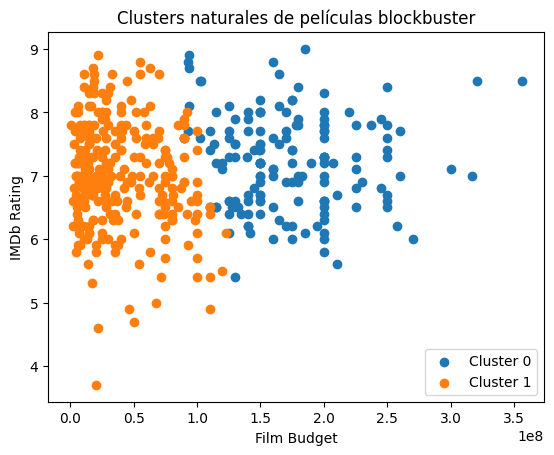

In [6]:
# Cargar datos
df = pd.read_csv("Blockbusters_2019-1977.csv", encoding="latin1")

# LIMPIEZA CRÍTICA
df["film_budget"] = (
    df["film_budget"]
    .astype(str)
    .str.replace(",", "")
    .astype(float)
)

# Variables relevantes
features_num = ["film_budget", "imdb_rating"]
features_cat = ["genre_1"]

X = df[features_num + features_cat].dropna()

# Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), features_num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), features_cat),
    ]
)

# Selección del mejor k con Silhouette
sil_scores = {}
for k in range(2, 7):
    pipe = Pipeline(
        steps=[
            ("prep", preprocessor),
            ("kmeans", KMeans(n_clusters=k, random_state=42, n_init=10)),
        ]
    )
    labels = pipe.fit_predict(X)
    sil_scores[k] = silhouette_score(
        pipe.named_steps["prep"].transform(X), labels
    )

best_k = max(sil_scores, key=sil_scores.get)

# Modelo final
model = Pipeline(
    steps=[
        ("prep", preprocessor),
        ("kmeans", KMeans(n_clusters=best_k, random_state=42, n_init=10)),
    ]
)

X["Cluster"] = model.fit_predict(X)

print("Silhouette scores por k:")
for k, v in sil_scores.items():
    print(f"k={k}: {v:.3f}")

print(f"\nMejor número de clusters: {best_k}")
print("\nPelículas por cluster:")
print(X["Cluster"].value_counts())

# Visualización
plt.figure()
for c in sorted(X["Cluster"].unique()):
    subset = X[X["Cluster"] == c]
    plt.scatter(subset["film_budget"], subset["imdb_rating"], label=f"Cluster {c}")

plt.xlabel("Film Budget")
plt.ylabel("IMDb Rating")
plt.legend()
plt.title("Clusters naturales de películas blockbuster")
plt.show()